#### This notebook analyses mixed layer depth (MLD) diagnostics in the ACCESS-OM2 experiments.

In [2]:
import cosima_cookbook as cc
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cmocean as cm
from scipy.optimize import curve_fit
from xhistogram.xarray import histogram

from dask.distributed import Client

%matplotlib inline

In [3]:
client = Client(n_workers=8)
display(client)

<Client: 'tcp://127.0.0.1:38319' processes=8 threads=8, memory=128.85 GB>

In [4]:
### Generate new session

db = '/scratch/e14/mp2135/access-om2/archive/databases/1deg_jra55_ryf_experiments_abrupt_spinup500.db'
session = cc.database.create_session(db)

cc.querying.get_experiments(session)

experiment  ncfiles
0                          1deg_jra55_ryf_cont    24764
1        1deg_jra55_ryf_rcp45warm_x1_spinup500    42426
2        1deg_jra55_ryf_rcp45cool_x1_spinup500    42426
3     1deg_jra55_ryf_warm_0sat_8dwlw_spinup500    21206
4   1deg_jra55_ryf_warm_1.5sat_0dwlw_spinup500    21206
5              1deg_jra55_ryf_RCPwarm_humid_x1    42426
6              1deg_jra55_ryf_RCPwarm_humid_x2    42207
7              1deg_jra55_ryf_RCPcool_humid_x1    42207
8              1deg_jra55_ryf_RCPcool_humid_x2    42426
9               1deg_jra55_ryf_wcwc_step_test1     2108
10              1deg_jra55_ryf_wcwc_step_test2     4230
11          1deg_jra55_ryf_sinusoid_x1_period2    44968
12          1deg_jra55_ryf_sinusoid_x1_period5    44790
13         1deg_jra55_ryf_sinusoid_x1_period20    44968
14         1deg_jra55_ryf_sinusoid_x1_period10    44968
15          1deg_jra55_ryf_sinusoid_x1_period7     2626
16         1deg_jra55_ryf_sinusoid_x1_period12     2626
17         1deg_jra55_ryf_sinusoid_x1_period16     2626

In [5]:
# Mixed layer depth: "mixed layer depth determined by density criteria"

yr_beg = '2400-01-16'

expt = '1deg_jra55_ryf_cont'
var = 'mld'
frequency = '1 monthly'
mld_cont = cc.querying.getvar(expt, var, session, start_time = yr_beg).groupby('time.year').mean(dim='time').chunk(chunks='auto') 

### Aburpt simulations

In [6]:
expt = '1deg_jra55_ryf_RCPwarm_humid_x1'
var = 'mld'
frequency = '1 monthly'
mld_warmx1 = cc.querying.getvar(expt, var, session, start_time = yr_beg).groupby('time.year').mean(dim='time').chunk(chunks='auto') 

In [7]:
# expt = '1deg_jra55_ryf_RCPwarm_humid_x2'
# var = 'mld'
# frequency = '1 monthly'
# mld_warmx2 = cc.querying.getvar(expt, var, session, start_time = yr_beg).groupby('time.year').mean(dim='time').chunk(chunks='auto') 

In [8]:
expt = '1deg_jra55_ryf_RCPcool_humid_x1'
var = 'mld'
frequency = '1 monthly'
mld_coolx1 = cc.querying.getvar(expt, var, session, start_time = yr_beg).groupby('time.year').mean(dim='time').chunk(chunks='auto') 

In [9]:
# expt = '1deg_jra55_ryf_RCPcool_humid_x2'
# var = 'mld'
# frequency = '1 monthly'
# mld_coolx2 = cc.querying.getvar(expt, var, session, start_time = yr_beg).groupby('time.year').mean(dim='time').chunk(chunks='auto') 

In [10]:
mld_cont = mld_cont.load()
mld_warmx1 = mld_warmx1.load()
mld_coolx1 = mld_coolx1.load()
# mld_warmx2 = mld_warmx2.load()
#mld_coolx2 = mld_coolx2.load()

In [38]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize = (25, 11))

year_index = 10


axs = ax[0]
cool = ((mld_coolx1 - mld_cont).isel(year=year_index)).plot(ax=axs, add_colorbar=False, cmap = 'RdBu_r')
axs.set_title('Temperature, 1 x cooling', fontsize=20)
# axs.set_ylabel('Depth (m)', fontsize=16)
# axs.set_xlabel('Year', fontsize=16)
# axs.set_xticklabels(xlabels, fontsize=15)

axs = ax[1]
warm = ((mld_warmx1 - mld_cont).isel(year=year_index)).plot(ax=axs, add_colorbar=False, cmap = 'RdBu_r')
axs.set_title('Temperature, 1 x warming', fontsize=20)
# axs.set_ylabel('Depth (m)', fontsize=16)
# axs.set_xlabel('Year', fontsize=16)
# axs.set_xticklabels(xlabels, fontsize=15)

cb = plt.colorbar(cool, orientation='vertical', shrink = 0.9, aspect = 50, pad = 0.03)
cb.set_label(label='Temperature anomaly (K)', fontsize=18)
#plt.savefig('temp_hovmoller_sinusoidal.jpg')

In [11]:
def area_weighted_ave(tracer, expt):
    area_t = cc.querying.getvar(expt, 'area_t', session, n=1).load() # area of cells
    area_total = area_t.sum(dim=('xt_ocean', 'yt_ocean')) # total area of ocean
    
    return (area_t * tracer).sum(dim=('xt_ocean', 'yt_ocean')) / area_total

In [12]:
# Global means:

expt = '1deg_jra55_ryf_cont'
tracer = mld_cont
mld_cont_ave = area_weighted_ave(tracer, expt)

expt = '1deg_jra55_ryf_RCPwarm_humid_x1'
tracer = mld_warmx1
mld_warmx1_ave = area_weighted_ave(tracer, expt)

expt = '1deg_jra55_ryf_RCPcool_humid_x1'
tracer = mld_coolx1
mld_coolx1_ave = area_weighted_ave(tracer, expt)

# expt = '1deg_jra55_ryf_RCPwarm_humid_x2'
# tracer = mld_warmx2
# mld_warmx2_ave = area_weighted_ave(tracer, expt)

# expt = '1deg_jra55_ryf_RCPcool_humid_x2'
# tracer = mld_coolx2
# mld_coolx2_ave = area_weighted_ave(tracer, expt)

In [13]:
plt.figure(figsize = (19,12))

zero = xr.DataArray(data=[0], dims='year', coords={"year": [2399]})
mld_warmx1_anom = xr.concat([zero, (mld_warmx1_ave - mld_cont_ave) / mld_cont_ave], dim='year')
mld_coolx1_anom = xr.concat([zero, (mld_coolx1_ave - mld_cont_ave) / mld_cont_ave], dim='year')
# mld_warmx2_anom = xr.concat([zero, (mld_warmx2 - mld_cont) / mld_cont], dim='year')
# mld_coolx2_anom = xr.concat([zero, (mld_coolx2 - mld_cont) / mld_cont], dim='year')

mld_warmx1_anom_mean = xr.full_like((mld_warmx1_ave - mld_cont_ave) / mld_cont_ave, ((mld_warmx1_ave - mld_cont_ave) / mld_cont_ave).mean(dim='year'))
mld_coolx1_anom_mean = xr.full_like((mld_coolx1_ave - mld_cont_ave) / mld_cont_ave, ((mld_coolx1_ave - mld_cont_ave) / mld_cont_ave).mean(dim='year'))
# mld_warmx2_anom_mean = xr.full_like((mld_warmx2 - mld_cont) / mld_cont, ((mld_warmx2 - mld_cont) / mld_cont).mean(dim='year'))
# mld_coolx2_anom_mean = xr.full_like((mld_coolx2 - mld_cont) / mld_cont, ((mld_coolx2 - mld_cont) / mld_cont).mean(dim='year'))

( - 1 * mld_warmx1_anom).plot(label='Warming x $-1$', color = 'r')
mld_coolx1_anom.plot(label='Cooling', color = 'b')
# ( - 0.5 * mld_warmx2_anom).plot(label='Double warming x $-0.5$', color = 'r', linestyle = ':')
# (0.5 * mld_coolx2_anom).plot(label='Double Cooling x $0.5$', color = 'b', linestyle = ':')

plt.title('Annually averaged global average mixed layer depth anomaly', fontsize=20)
plt.ylabel('Fractional change in MLD', fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Years', fontsize=16)
plt.xticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid()
plt.savefig('step_mld_anoms.jpg')

### Sinusoidal simulations

In [54]:
expt = '1deg_jra55_ryf_sinusoid_x1_period2'
var = 'mld'
frequency = '1 yearly'
mld_period2 = cc.querying.getvar(expt, var, session, start_time = yr_beg).groupby('time.year').mean(dim='time').chunk(chunks='auto') 

In [55]:
expt = '1deg_jra55_ryf_sinusoid_x1_period5'
var = 'mld'
frequency = '1 yearly'
mld_period5 = cc.querying.getvar(expt, var, session, start_time = yr_beg).groupby('time.year').mean(dim='time').chunk(chunks='auto') 

In [56]:
expt = '1deg_jra55_ryf_sinusoid_x1_period10'
var = 'mld'
frequency = '1 yearly'
mld_period10 = cc.querying.getvar(expt, var, session, start_time = yr_beg).groupby('time.year').mean(dim='time').chunk(chunks='auto') 

In [57]:
expt = '1deg_jra55_ryf_sinusoid_x1_period20'
var = 'mld'
frequency = '1 yearly'
mld_period20 = cc.querying.getvar(expt, var, session, start_time = yr_beg).groupby('time.year').mean(dim='time').chunk(chunks='auto') 

In [58]:
mld_cont.load()
mld_period2.load()
mld_period5.load()
mld_period10.load()
mld_period20.load()

<xarray.DataArray 'mld' (year: 105, yt_ocean: 300, xt_ocean: 360)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
  * year      (year) int64 2400 2401 2402 2403 2404 ... 2500 2501 2502 2503 2504

In [64]:
# Zonal means:

expt = '1deg_jra55_ryf_sinusoid_x1_period2'
tracer = mld_period2
mld_period2_zonal = true_zonal_mean(tracer, expt)

expt = '1deg_jra55_ryf_sinusoid_x1_period5'
tracer = mld_period5
mld_period5_zonal = true_zonal_mean(tracer, expt)

expt = '1deg_jra55_ryf_sinusoid_x1_period10'
tracer = mld_period10
mld_period10_zonal = true_zonal_mean(tracer, expt)

expt = '1deg_jra55_ryf_sinusoid_x1_period20'
tracer = mld_period20
mld_period20_zonal = true_zonal_mean(tracer, expt)

In [75]:
expt = '1deg_jra55_ryf_sinusoid_x1_period2'
dzt = cc.querying.getvar(expt, 'dzt', session)

ValueError: Resulting object does not have monotonic global indexes along dimension time

In [68]:
# Naive zonal mean

mld_cont_zonal = mld_cont.mean(dim=('xt_ocean', 'yt_ocean'))
mld_period2_zonal = mld_period2.mean(dim=('xt_ocean', 'yt_ocean'))
mld_period5_zonal = mld_period5.mean(dim=('xt_ocean', 'yt_ocean'))
mld_period10_zonal = mld_period10.mean(dim=('xt_ocean', 'yt_ocean'))
mld_period20_zonal = mld_period20.mean(dim=('xt_ocean', 'yt_ocean'))

In [51]:
# # True zonal mean

# mld_period2_zonal = mld_period2_zonal.mean(dim=('geolat_t_bin', 'st_ocean'))
# mld_period5_zonal = mld_period5_zonal.mean(dim=('geolat_t_bin', 'st_ocean'))
# mld_period10_zonal = mld_period10_zonal.mean(dim=('geolat_t_bin', 'st_ocean'))
# mld_period20_zonal = mld_period20_zonal.mean(dim=('geolat_t_bin', 'st_ocean'))

<Figure size 1368x864 with 0 Axes>

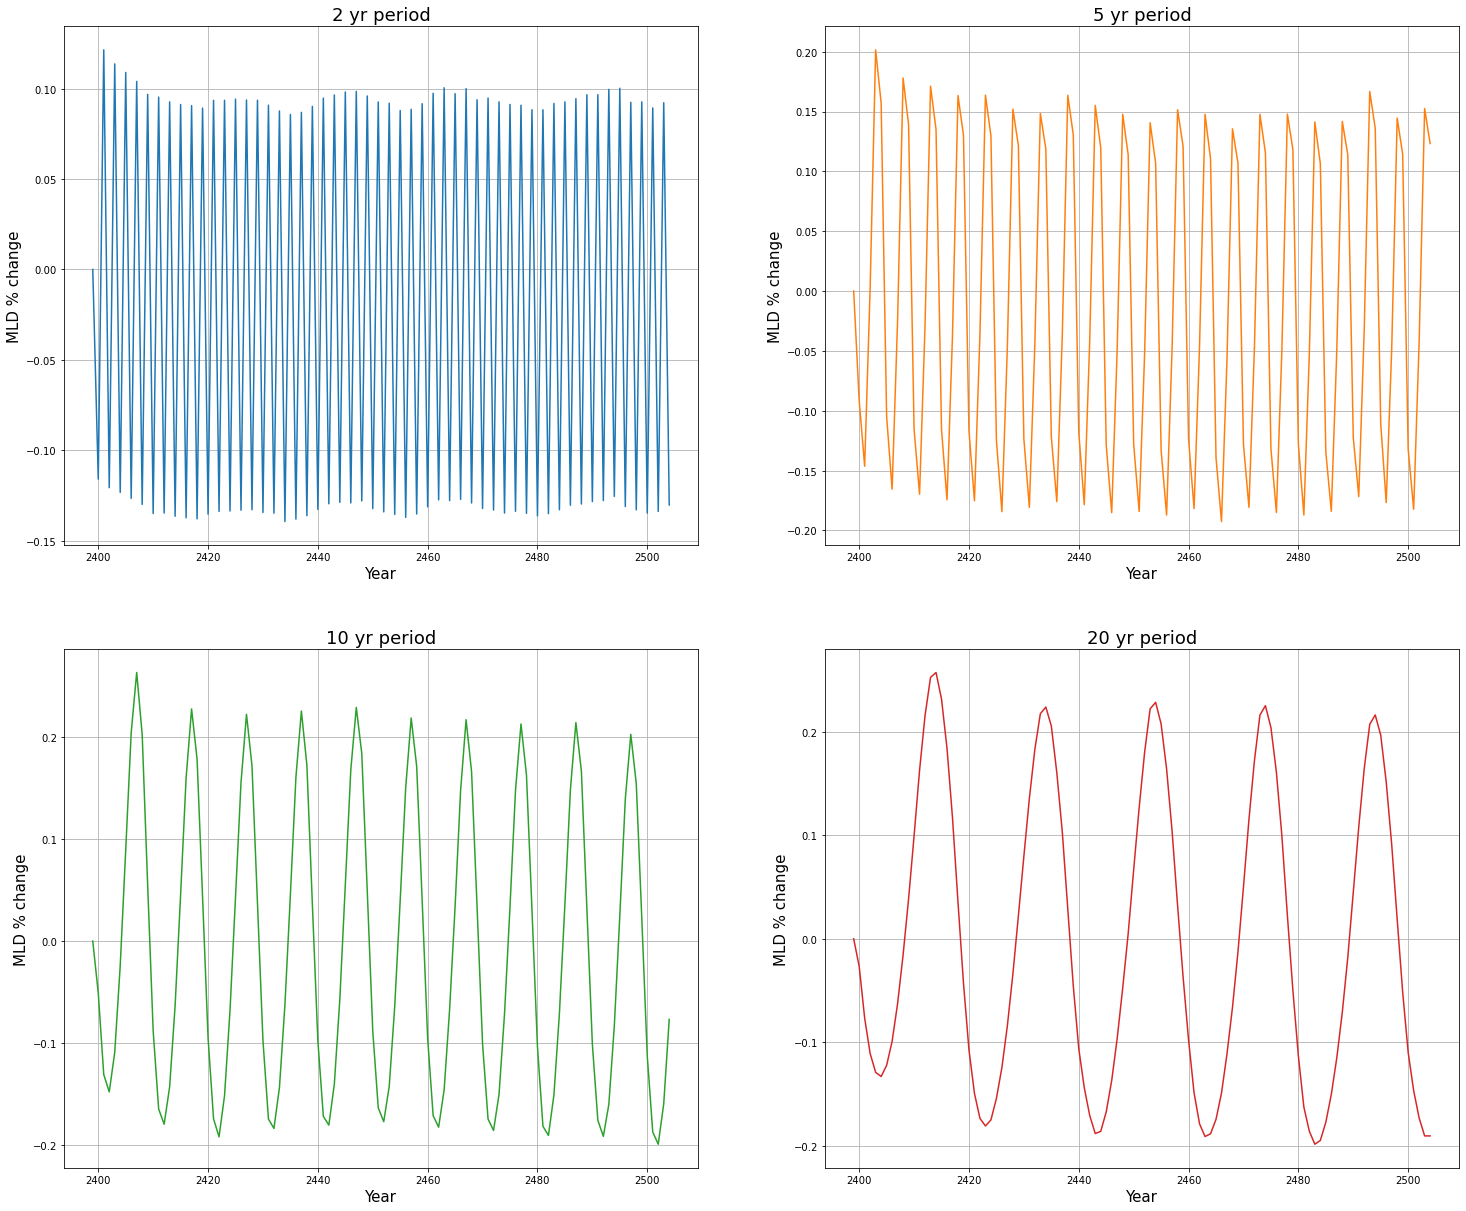

In [74]:
plt.figure(figsize = (19,12))

zero = xr.DataArray(data=[0], dims='year', coords={"year": [2399]})
mld_period2_anom = xr.concat([zero, (mld_period2_zonal - mld_cont_zonal) / mld_cont_zonal], dim='year')
mld_period5_anom = xr.concat([zero, (mld_period5_zonal - mld_cont_zonal) / mld_cont_zonal], dim='year')
mld_period10_anom = xr.concat([zero, (mld_period10_zonal - mld_cont_zonal) / mld_cont_zonal], dim='year')
mld_period20_anom = xr.concat([zero, (mld_period20_zonal - mld_cont_zonal) / mld_cont_zonal], dim='year')

fig, ax = plt.subplots(ncols=2, nrows=2, figsize = (25, 21))

axs = ax[0, 0]
mld_period2_anom.plot(ax=axs, color = 'C0')
axs.set_title('2 yr period', fontsize=18)
axs.set_ylabel('MLD % change', fontsize=15)
axs.set_xlabel('Year', fontsize=15)
axs.grid()

axs = ax[0, 1]
mld_period5_anom.plot(ax=axs, color = 'C1')
axs.set_title('5 yr period', fontsize=18)
axs.set_ylabel('MLD % change', fontsize=15)
axs.set_xlabel('Year', fontsize=15)
axs.grid()

axs = ax[1, 0]
mld_period10_anom.plot(ax=axs, color = 'C2')
axs.set_title('10 yr period', fontsize=18)
axs.set_ylabel('MLD % change', fontsize=15)
axs.set_xlabel('Year', fontsize=15)
axs.grid()

axs = ax[1, 1]
mld_period20_anom.plot(ax=axs, color = 'C3')
axs.set_title('20 yr period', fontsize=18)
axs.set_ylabel('MLD % change', fontsize=15)
axs.set_xlabel('Year', fontsize=15)
axs.grid()

# plt.savefig('sinusoidal_mld_anoms.jpg')